
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fblaura/FraudD/blob/main/3_GridSearch/1_GridSearch_for_models_with_StandardScaler_and_SMOTE_rate_of_0_1.ipynb)

**Please execute all instructions as indicated.** 

The dataset is downloaded directly from a Drive link, this dataset already went through a previous preprocessing.We will work on hyperparameter tuning for the GradientBoosting and XGBoost models, as well as use some plots and metrics to evaluate training and prediction behavior.

**Some functions and graphs are mentioned in Spanish, please translate them if required.**

# **1. General libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, cross_val_predict, validation_curve
from datetime import datetime
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score,plot_roc_curve, classification_report,log_loss,recall_score,adjusted_rand_score
import pickle

In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, roc_curve,precision_score,roc_auc_score

# **2. Defining different functions**

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    plt.style.use('seaborn')
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def impresión_reporte(nclusters,Y,labels):
  
  print(f'Reporte de métricas para KMeans con clusters = {nclusters}')
  print('-'*80)
  print(f'Log_loss = {log_loss(Y, labels)}')
  print(f'Puntuación de exactitud = {accuracy_score(Y, labels)}')
  print(f'Puntuación de sensibilidad = {recall_score(Y, labels)}')
  print(f'Puntuación de precisión = {precision_score(Y, labels)}')
  print(f'Puntuación de Rand ajustado = {adjusted_rand_score(Y, labels)}')
  print(f'Puntuación de Jaccard = {jaccard_score(Y, labels)}')
  cmtx = pd.DataFrame(
      confusion_matrix(Y, labels, labels=[1, 0]), 
      index=['Fraude:1', 'NoFraude:0'], 
      columns=['Fraude:1', 'NoFraude:0']
  )
  print('Matriz de confusión = ')
  print(cmtx)

In [ ]:
def classifier_model(X_train, X_test, y_train, y_test, method, data):
    accuracies, roc_auc,f1=[],[],[]
    modelos=['Random Forest','Gradient Boosting','XGBoost','Regresión logística','Naive Bayes','SVM']
    rf_clf=RandomForestClassifier(n_estimators=700, random_state=1)
    rf_clf.fit(X_train, y_train)
    y_pred_rf=rf_clf.predict(X_test)
    score_rlf=accuracy_score(y_test, y_pred_rf)
    roc_auc_rlf=roc_auc_score(y_test, y_pred_rf)
    f1_sco=f1_score(y_test, y_pred_rf,average='macro')
    accuracies.append(score_rlf)
    roc_auc.append(roc_auc_rlf)
    f1.append(f1_sco)
    print("---Método de trabajo: {}---". format(method))
    print("---Observando comportamiendo de métricas para {}---".format(data))
    print("The accuracy score of Random Forest:", score_rlf)
    print("The ROC_AUC score of Random Forest:", roc_auc_rlf)
    print("The F1 score of Random Forest:", f1_sco)
    print('---------------------------------------------------')
    
    gb_clf= GradientBoostingClassifier(learning_rate=0.1, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
    gb_clf.fit(X_train, y_train)
    y_pred_gb=gb_clf.predict(X_test)
    score_gb=accuracy_score(y_test, y_pred_gb)
    roc_auc_gb=roc_auc_score(y_test,  y_pred_gb)
    f1_sco_gb=f1_score(y_test, y_pred_gb,average='micro')
    accuracies.append(score_gb)
    roc_auc.append(roc_auc_gb)
    f1.append(f1_sco_gb)
    print("The accuracy score of Gradient Boosting:", score_gb)
    print("The ROC_AUC score of Gradient Boosting:", roc_auc_gb)
    print("The F1 score of Gradient Boosting:", f1_sco_gb)

    print('---------------------------------------------------')
    xg_clf=XGBClassifier()
    xg_clf.fit(X_train, y_train)
    y_pred_xg=xg_clf.predict(X_test)
    score_xg=accuracy_score(y_test, y_pred_xg)
    roc_auc_xg=roc_auc_score(y_test, y_pred_xg)
    f1_sco_xg=f1_score(y_test, y_pred_xg,average='micro')
    accuracies.append(score_xg)
    roc_auc.append(roc_auc_xg)
    f1.append(f1_sco_xg)
    print("The accuracy score of XGBoost:", score_xg)
    print("The ROC_AUC score of XGBoost:", roc_auc_xg)
    print("The F1 score of XGBoost:", f1_sco_xg)
    print('---------------------------------------------------')
    clf = LogisticRegression(random_state=0, max_iter=5000)
    clf.fit(X_train, y_train)
    y_pred_l=clf.predict(X_test)
    score_l=accuracy_score(y_test, y_pred_l)
    roc_auc_l=roc_auc_score(y_test, y_pred_l)
    f1_sco_l=f1_score(y_test, y_pred_l,average='micro')
    accuracies.append(score_l)
    roc_auc.append(roc_auc_l)
    f1.append(f1_sco_l)
    print("The accuracy score of Regresión logística:", score_l)
    print("The ROC_AUC score of Regresión logística:", roc_auc_l)  
    print("The F1 score of Regresión logística:", f1_sco_l)
    print('---------------------------------------------------')
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred_gnb=gnb.predict(X_test)
    score_gnb=accuracy_score(y_test, y_pred_gnb)
    roc_auc_gnb=roc_auc_score(y_test, y_pred_gnb)
    f1_sco_gnb=f1_score(y_test, y_pred_gnb,average='micro')
    accuracies.append(score_gnb)
    roc_auc.append(roc_auc_gnb)
    f1.append(f1_sco_gnb)
    print("The accuracy score of Naive Bayes:", score_gnb)
    print("The ROC_AUC score of Naive Bayes:", roc_auc_gnb)   
    print("The F1 score of Naive Bayes:", f1_sco_gnb)
    print('---------------------------------------------------')
    svc=LinearSVC()
    svc.fit(X_train, y_train)
    y_pred_svc=svc.predict(X_test)
    score_svc=accuracy_score(y_test, y_pred_svc)
    roc_auc_svc=roc_auc_score(y_test, y_pred_svc)
    f1_sco_svc=f1_score(y_test, y_pred_svc,average='micro')
    accuracies.append(score_svc)
    roc_auc.append(roc_auc_svc)
    f1.append(f1_sco_svc)
    print("The accuracy score of SVM:", score_svc)
    print("The ROC_AUC score of SVM:", roc_auc_svc)  
    print("The F1 score of Naive Bayes:", f1_sco_svc)
    return  accuracies, roc_auc,f1, modelos

In [ ]:
def autolabel(rects):
    for rect in rects:
        
        width = rect.get_width()
        plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                 '%.2f' % float(width),
                 ha='center', va='center')

In [ ]:
def labels(rects):
  for p in rects.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),((p.get_x()-0.15)+p.get_width(), p.get_height()+2),ha='center',va='center')

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
    return thour,tmin,tsec

# **3. Dataset definition**

The following code will be used to download the dataset from a Drive storage, this is because the volume of the dataset being handled is very large and it is not possible to upload it directly to GitHub

In [ ]:
from google.colab import files

In [ ]:
#train_fill
!gdown --id 10lD33nbEwBF7XpgQiVRfWzO2Y0pUY3nA

Downloading...
From: https://drive.google.com/uc?id=10lD33nbEwBF7XpgQiVRfWzO2Y0pUY3nA
To: /content/X_trainss_01.csv
100% 686M/686M [00:03<00:00, 174MB/s]


In [ ]:
X_trainss_01 = pd.read_csv('/content/X_trainss_01.csv',error_bad_lines=False)

b'Skipping line 74954: expected 432 fields, saw 489\n'


In [ ]:
X_trainss_01

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_35,id_36,id_37,id_38,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,CurrencyCents,CurrencyDollar,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,MobileCompareSerial,TransactionID,TransactionDT,card1,CentsDigits,isFraud
0,0.73600,-2.438198,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,2.922440,-0.423689,1.640759,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.286590,0.041363,-0.274044,-1.448447,0.229787,0.168792,-0.124002,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,0.516788,-0.287635,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.732027,-1.756537,0.818050,-0.670784,0
1,0.73600,-0.904898,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,-0.411229,2.360224,1.640759,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.478321,0.224814,-0.274044,-2.435659,0.329704,0.168792,-0.168789,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.476956,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731980,-1.756535,-1.451410,-0.670784,0
2,0.73600,0.628401,0.702593,0.842275,-0.083186,0.0,0.186352,0.281360,-0.411229,-0.423689,-0.609474,-0.158137,-0.265768,-6.211912,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.332703,0.768843,-0.274044,-0.856119,0.379663,0.168792,1.076299,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.331325,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731932,-1.756384,-1.063787,-0.670784,0
3,0.73600,-0.904898,0.702593,1.963293,-0.083186,0.0,0.186352,0.281360,-0.411229,2.360224,-0.609474,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.376388,1.255938,-0.274044,-2.065454,1.838456,0.168792,-0.168789,-0.097562,-0.134878,-0.129379,-0.103497,-0.129767,-0.201776,-0.131187,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.375014,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731885,-1.756318,1.672526,-0.670784,0
4,-1.25103,-0.904898,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,-0.411229,-0.423689,-0.609474,-0.158137,-0.265768,0.160981,0.217591,1.747812,0.447464,0.072847,-0.003701,2.295501,2.239898,0.326466,-0.167966,0.292131,0.278315,-0.376388,0.920665,-0.274044,-2.435659,1.278919,0.168792,-0.168789,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.

In [ ]:
Y = X_trainss_01['isFraud']
X = X_trainss_01.drop(['isFraud', 'TransactionID'], axis=1)

In [ ]:
target_n=pd.unique(Y)
target_n

array([0, 1])

# **4. GridSearch for GradientBoostingClassifier with StandardScaler and SMOTE 0.1**

## **A. Learning_rate and n_estimators**

In this situation it is possible to observe that by specifying two parameters the training takes less than 1 minute, which facilitates the training and the adjustment of these parameters. 

In [ ]:
gbc1 = GradientBoostingClassifier(random_state=10, max_features = 'sqrt', learning_rate=0.01)
parameters = {
    "n_estimators":[200,300,500, 700, 1000, 1500],
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring1 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch1 = GridSearchCV(estimator=gbc1,param_grid=parameters,scoring=scoring1, cv=10, verbose=3, refit='AUC', return_train_score=True)
gsearch1.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, n_estimators=200, AUC=(train=0.897, test=0.567), Accuracy=(train=0.933, test=0.920), F1=(train=0.933, test=0.920), total=  15.5s
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=200, AUC=(train=0.899, test=0.824), Accuracy=(train=0.932, test=0.930), F1=(train=0.932, test=0.930), total=  15.4s
[CV] learning_rate=0.01, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.9s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=200, AUC=(train=0.898, test=0.870), Accuracy=(train=0.932, test=0.930), F1=(train=0.932, test=0.930), total=  14.8s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, AUC=(train=0.887, test=0.900), Accuracy=(train=0.931, test=0.932), F1=(train=0.931, test=0.932), total=  13.7s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, AUC=(train=0.888, test=0.884), Accuracy=(train=0.932, test=0.932), F1=(train=0.932, test=0.932), total=  13.8s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, AUC=(train=0.888, test=0.905), Accuracy=(train=0.932, test=0.935), F1=(train=0.932, test=0.935), total=  14.1s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, AUC=(train=0.889, test=0.883), Accuracy=(train=0.932

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 218.9min finished



 Time taken: 3 hours 39 minutes and 48.82 seconds.


With some code you can observe as well, the best parameter and the training score obtained for that dataset.

In [ ]:
#gsearch1.grid_scores_,
gsearch1.best_params_, gsearch1.best_score_


({'learning_rate': 0.1, 'n_estimators': 700}, 0.8747180761493383)

## **B. min_samples_split y min_samples_leaf**

According to Scikit-Learn's documentation, `min_samples_split` specifies the minimum number of samples required to split an internal node, while `min_samples_leaf` specifies the minimum number of samples required to be at a leaf node. For that reason, we choose a random range of numbers to evaluate with GBC.

In [ ]:
gbc2 = GradientBoostingClassifier(random_state=10, max_features = 'sqrt', learning_rate=lr, n_estimators=nest)
parameters2 = {
    'min_samples_split':range(7000,10000,500),
    'min_samples_leaf':range(5000,6000,200)
}
scoring2 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch2 = GridSearchCV(estimator=gbc2,param_grid=parameters2,scoring=scoring2, cv=10, verbose=3, refit='AUC', return_train_score=True)
gsearch2.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] min_samples_leaf=5000, min_samples_split=7000 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_leaf=5000, min_samples_split=7000, AUC=(train=0.978, test=0.879), Accuracy=(train=0.972, test=0.933), F1=(train=0.972, test=0.933), total=  46.5s
[CV] min_samples_leaf=5000, min_samples_split=7000 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.3s remaining:    0.0s


[CV]  min_samples_leaf=5000, min_samples_split=7000, AUC=(train=0.978, test=0.715), Accuracy=(train=0.973, test=0.906), F1=(train=0.973, test=0.906), total=  43.4s
[CV] min_samples_leaf=5000, min_samples_split=7000 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV]  min_samples_leaf=5000, min_samples_split=7000, AUC=(train=0.977, test=0.797), Accuracy=(train=0.972, test=0.930), F1=(train=0.972, test=0.930), total=  44.3s
[CV] min_samples_leaf=5000, min_samples_split=7000 ...................
[CV]  min_samples_leaf=5000, min_samples_split=7000, AUC=(train=0.966, test=0.980), Accuracy=(train=0.968, test=0.971), F1=(train=0.968, test=0.971), total=  43.8s
[CV] min_samples_leaf=5000, min_samples_split=7000 ...................
[CV]  min_samples_leaf=5000, min_samples_split=7000, AUC=(train=0.968, test=0.964), Accuracy=(train=0.969, test=0.957), F1=(train=0.969, test=0.957), total=  45.0s
[CV] min_samples_leaf=5000, min_samples_split=7000 ...................
[CV]  min_samples_leaf=5000, min_samples_split=7000, AUC=(train=0.966, test=0.983), Accuracy=(train=0.967, test=0.972), F1=(train=0.967, test=0.972), total=  44.4s
[CV] min_samples_leaf=5000, min_samples_split=7000 ...................
[CV]  min_samples_leaf=5000, min_samples_split=7000, AUC=(tr

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 260.9min finished



 Time taken: 4 hours 21 minutes and 36.99 seconds.


Observe best parameter and training score

In [ ]:
gsearch2.best_params_, gsearch2.best_score_


({'min_samples_leaf': 5000, 'min_samples_split': 7000}, 0.9233695400440594)

## **C. max_depth**

In [ ]:
gbc3 = GradientBoostingClassifier(random_state=10, max_features = 'sqrt',learning_rate=0.1, n_estimators=700,min_samples_split=7000, min_samples_leaf=5000)
parameters3 = {
    "max_depth":[15,20,25,35]
}
scoring3 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch3 = GridSearchCV(estimator=gbc3,param_grid=parameters3,scoring=scoring3, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch3.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV] max_depth=15 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=15, AUC=(train=0.987, test=0.890), Accuracy=(train=0.980, test=0.935), F1=(train=0.980, test=0.935), total=  51.1s
[CV] max_depth=15 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.1s remaining:    0.0s


[CV]  max_depth=15, AUC=(train=0.989, test=0.662), Accuracy=(train=0.982, test=0.898), F1=(train=0.982, test=0.898), total=  50.6s
[CV] max_depth=15 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV]  max_depth=15, AUC=(train=0.979, test=0.909), Accuracy=(train=0.976, test=0.945), F1=(train=0.976, test=0.945), total=  49.6s
[CV] max_depth=15 ....................................................
[CV]  max_depth=15, AUC=(train=0.976, test=0.973), Accuracy=(train=0.974, test=0.956), F1=(train=0.974, test=0.956), total=  48.7s
[CV] max_depth=15 ....................................................
[CV]  max_depth=15, AUC=(train=0.976, test=0.986), Accuracy=(train=0.974, test=0.970), F1=(train=0.974, test=0.970), total=  49.4s
[CV] max_depth=15 ....................................................
[CV]  max_depth=15, AUC=(train=0.976, test=0.979), Accuracy=(train=0.974, test=0.962), F1=(train=0.974, test=0.962), total=  50.7s
[CV] max_depth=15 ....................................................
[CV]  max_depth=15, AUC=(train=0.976, test=0.981), Accuracy=(train=0.974, test=0.973), F1=(train=0.974, test=0.973), total=  50.6s
[CV] max_depth=15 ...........................................

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 31.2min finished



 Time taken: 0 hours 32 minutes and 16.78 seconds.


In [ ]:
gsearch3.best_params_, gsearch3.best_score_


({'max_depth': 15}, 0.9209325293591377)

### **C.1. max_depth sin min_samples**

In [ ]:
gbc4 = GradientBoostingClassifier(random_state=10, max_features = 'sqrt',learning_rate=0.1, n_estimators=700)
parameters4 = {
    "max_depth":[10,15,20,25,35,40]
}
scoring4 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch3 = GridSearchCV(estimator=gbc4,param_grid=parameters4,scoring=scoring4, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch3.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 6 candidates, totalling 48 fits
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, AUC=(train=1.000, test=0.709), Accuracy=(train=1.000, test=0.887), F1=(train=1.000, test=0.887), total= 1.9min
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  max_depth=10, AUC=(train=1.000, test=0.814), Accuracy=(train=1.000, test=0.936), F1=(train=1.000, test=0.936), total= 1.8min
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s


[CV]  max_depth=10, AUC=(train=1.000, test=0.951), Accuracy=(train=1.000, test=0.979), F1=(train=1.000, test=0.979), total= 2.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=1.000, test=0.998), Accuracy=(train=1.000, test=0.969), F1=(train=1.000, test=0.969), total= 2.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=1.000, test=0.998), Accuracy=(train=1.000, test=0.960), F1=(train=1.000, test=0.960), total= 2.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=1.000, test=0.996), Accuracy=(train=1.000, test=0.945), F1=(train=1.000, test=0.945), total= 2.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.986), F1=(train=1.000, test=0.986), total= 2.2min
[CV] max_depth=10 ...........................................

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 72.2min finished



 Time taken: 1 hours 13 minutes and 50.34 seconds.


In [ ]:
gsearch3.best_params_, gsearch3.best_score_


({'max_depth': 20}, 0.9487242208055615)

Although the choice of the min_samples range increased the training score, the model did better without these parameters. Therefore, this parameter setting is discarded. 

## **D. max_features**

In [ ]:
gbc5 = GradientBoostingClassifier(random_state=10, learning_rate=0.1, n_estimators=700,  max_depth=20)
parameters5 = {
    "max_features":[15,20,30,100,200]
}
scoring5 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch5 = GridSearchCV(estimator=gbc5,param_grid=parameters5,scoring=scoring5, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch5.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 5 candidates, totalling 40 fits
[CV] max_features=15 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=15, AUC=(train=1.000, test=0.775), Accuracy=(train=1.000, test=0.954), F1=(train=1.000, test=0.954), total= 1.7min
[CV] max_features=15 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  max_features=15, AUC=(train=1.000, test=0.927), Accuracy=(train=1.000, test=0.952), F1=(train=1.000, test=0.952), total= 1.6min
[CV] max_features=15 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV]  max_features=15, AUC=(train=1.000, test=0.980), Accuracy=(train=1.000, test=0.985), F1=(train=1.000, test=0.985), total= 1.8min
[CV] max_features=15 .................................................
[CV]  max_features=15, AUC=(train=1.000, test=0.998), Accuracy=(train=1.000, test=0.986), F1=(train=1.000, test=0.986), total= 1.8min
[CV] max_features=15 .................................................
[CV]  max_features=15, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.992), F1=(train=1.000, test=0.992), total= 1.8min
[CV] max_features=15 .................................................
[CV]  max_features=15, AUC=(train=1.000, test=0.995), Accuracy=(train=1.000, test=0.962), F1=(train=1.000, test=0.962), total= 1.8min
[CV] max_features=15 .................................................
[CV]  max_features=15, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.988), F1=(train=1.000, test=0.988), total= 1.9min
[CV] max_features=15 .........................

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 131.1min finished



 Time taken: 2 hours 13 minutes and 20.01 seconds.


In [ ]:
gsearch5.best_params_, gsearch5.best_score_


({'max_features': 15}, 0.9554628904735567)

## **E. subsample**

In [ ]:
gbc6 = GradientBoostingClassifier(random_state=10, learning_rate=0.1, n_estimators=700,  max_depth=20, max_features=15)
parameters6 = {
    'subsample':[0.7,0.8,0.9,1]
}
scoring6 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch6 = GridSearchCV(estimator=gbc6,param_grid=parameters6,scoring=scoring6, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch6.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV] subsample=0.7 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, AUC=(train=1.000, test=0.769), Accuracy=(train=1.000, test=0.949), F1=(train=1.000, test=0.949), total= 1.7min
[CV] subsample=0.7 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  subsample=0.7, AUC=(train=1.000, test=0.929), Accuracy=(train=1.000, test=0.952), F1=(train=1.000, test=0.952), total= 1.6min
[CV] subsample=0.7 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV]  subsample=0.7, AUC=(train=1.000, test=0.979), Accuracy=(train=1.000, test=0.986), F1=(train=1.000, test=0.986), total= 1.8min
[CV] subsample=0.7 ...................................................
[CV]  subsample=0.7, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.989), F1=(train=1.000, test=0.989), total= 1.8min
[CV] subsample=0.7 ...................................................
[CV]  subsample=0.7, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.992), F1=(train=1.000, test=0.992), total= 1.8min
[CV] subsample=0.7 ...................................................
[CV]  subsample=0.7, AUC=(train=1.000, test=0.998), Accuracy=(train=1.000, test=0.979), F1=(train=1.000, test=0.979), total= 1.8min
[CV] subsample=0.7 ...................................................
[CV]  subsample=0.7, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.989), F1=(train=1.000, test=0.989), total= 1.8min
[CV] subsample=0.7 .....................................

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 60.6min finished



 Time taken: 1 hours 2 minutes and 39.38 seconds.


In [ ]:
gsearch6.best_params_, gsearch6.best_score_


({'subsample': 0.7}, 0.9556653442581189)

## **F. min_samples_leaf y min_samples_split**

On this occasion, a range of values close to the default value of Scikit-Learn was chosen. The intention is to observe if it is indeed a parameter that is worthwhile.

In [ ]:
gbc7 = GradientBoostingClassifier(random_state=10, learning_rate=0.1, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7)
parameters7 = {
    'min_samples_split':[2,4,6,10,40,100], 
    'min_samples_leaf':[1,3,5,7]
}
scoring7 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch7 = GridSearchCV(estimator=gbc7,param_grid=parameters7,scoring=scoring7, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch7.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 24 candidates, totalling 192 fits
[CV] min_samples_leaf=1, min_samples_split=2 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_leaf=1, min_samples_split=2, AUC=(train=1.000, test=0.769), Accuracy=(train=1.000, test=0.949), F1=(train=1.000, test=0.949), total= 1.6min
[CV] min_samples_leaf=1, min_samples_split=2 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, AUC=(train=1.000, test=0.929), Accuracy=(train=1.000, test=0.952), F1=(train=1.000, test=0.952), total= 1.6min
[CV] min_samples_leaf=1, min_samples_split=2 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, AUC=(train=1.000, test=0.979), Accuracy=(train=1.000, test=0.986), F1=(train=1.000, test=0.986), total= 1.8min
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.989), F1=(train=1.000, test=0.989), total= 1.8min
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.992), F1=(train=1.000, test=0.992), total= 1.8min
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, AUC=(train=1.000, test=0.998), Accuracy=(train=1.000, test=0.979), F1=(train=1.000, test=0.979), total= 1.8min
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, AUC=(train=1.000, test=0.999), Accura

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 333.2min finished



 Time taken: 5 hours 35 minutes and 3.8 seconds.


In [ ]:
gsearch7.best_params_, gsearch7.best_score_


({'min_samples_leaf': 3, 'min_samples_split': 2}, 0.9639806862134113)

## **G. random_state**

In [ ]:
gbc8 = GradientBoostingClassifier( learning_rate=0.1, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
parameters8 = {
    'random_state':[10,40,70,100]
}
scoring8 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch8 = GridSearchCV(estimator=gbc8,param_grid=parameters8,scoring=scoring8, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch8.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV] random_state=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  random_state=10, AUC=(train=1.000, test=0.826), Accuracy=(train=1.000, test=0.953), F1=(train=1.000, test=0.953), total= 1.4min
[CV] random_state=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  random_state=10, AUC=(train=1.000, test=0.928), Accuracy=(train=1.000, test=0.953), F1=(train=1.000, test=0.953), total= 1.4min
[CV] random_state=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


[CV]  random_state=10, AUC=(train=1.000, test=0.981), Accuracy=(train=1.000, test=0.986), F1=(train=1.000, test=0.986), total= 1.6min
[CV] random_state=10 .................................................
[CV]  random_state=10, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.989), F1=(train=1.000, test=0.989), total= 1.6min
[CV] random_state=10 .................................................
[CV]  random_state=10, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.993), F1=(train=1.000, test=0.993), total= 1.6min
[CV] random_state=10 .................................................
[CV]  random_state=10, AUC=(train=1.000, test=0.997), Accuracy=(train=1.000, test=0.966), F1=(train=1.000, test=0.966), total= 1.6min
[CV] random_state=10 .................................................
[CV]  random_state=10, AUC=(train=1.000, test=0.999), Accuracy=(train=1.000, test=0.991), F1=(train=1.000, test=0.991), total= 1.6min
[CV] random_state=10 .........................

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 53.5min finished



 Time taken: 0 hours 55 minutes and 16.76 seconds.


In [ ]:
gsearch8.best_params_, gsearch8.best_score_


({'random_state': 40}, 0.9642348620455258)

With the following code it is possible to view all training scores for the different partitions specified during GridSearch

In [ ]:
gsearch8.cv_results_


{'mean_fit_time': array([92.29432592, 91.39128387, 90.57659206, 89.9220047 ]),
 'mean_score_time': array([1.15199158, 1.12505707, 1.0545615 , 1.12370601]),
 'mean_test_AUC': array([0.96398069, 0.96423486, 0.96226218, 0.96284543]),
 'mean_test_Accuracy': array([0.94943562, 0.95672886, 0.94468014, 0.93854044]),
 'mean_test_F1': array([0.94943562, 0.95672886, 0.94468014, 0.93854044]),
 'mean_train_AUC': array([1., 1., 1., 1.]),
 'mean_train_Accuracy': array([1., 1., 1., 1.]),
 'mean_train_F1': array([1., 1., 1., 1.]),
 'param_random_state': masked_array(data=[10, 40, 70, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'random_state': 10},
  {'random_state': 40},
  {'random_state': 70},
  {'random_state': 100}],
 'rank_test_AUC': array([2, 1, 4, 3], dtype=int32),
 'rank_test_Accuracy': array([2, 1, 3, 4], dtype=int32),
 'rank_test_F1': array([2, 1, 3, 4], dtype=int32),
 'split0_test_AUC': array([0.82648718, 0.81731254,

Finally, a parameter setting has been made with the most commonly used GradientBoosting arguments. The training score has been increased from 87% to 96%. Finally, an analysis of the number of partitions in the GridSearch with respect to the training score will also be made. 

## **H. Learning_rate y CV** 

### **H.1. For two partitions, CV=2**

In [ ]:
# cv 2 
start_time = timer(None)
parameters = {
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
gb = GradientBoostingClassifier(random_state=40, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
gsearch = GridSearchCV(estimator=gb,param_grid=parameters,scoring=scoring, cv=2, refit='AUC', return_train_score=True)
gsearch.fit(X,Y)
print('Mejores parámetros',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Mejores evaluaciones',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Mejores parámetros {'learning_rate': 0.01}
Mejor score 0.8166499252893884
Mejores evaluaciones {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 0 hours 24 minutes and 51.01 seconds.


### **H.2. For four partitions, CV=4** 

In [ ]:
# cv 2 
start_time = timer(None)
parameters = {
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
gb = GradientBoostingClassifier(random_state=40, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
gsearch = GridSearchCV(estimator=gb,param_grid=parameters,scoring=scoring, cv=4, refit='AUC', return_train_score=True)
gsearch.fit(X,Y)
print('Mejores parámetros para 4 splits',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Evaluadores',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Mejores parámetros para 4 splits {'learning_rate': 0.1}
Mejor score 0.8946534037683964
Evaluadores {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 0 hours 59 minutes and 50.85 seconds.


### **H.3. For five partitions, CV=5**

In [ ]:
# cv 2 
start_time = timer(None)
parameters = {
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
gb = GradientBoostingClassifier(random_state=40, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
gsearch = GridSearchCV(estimator=gb,param_grid=parameters,scoring=scoring, cv=5, refit='AUC', return_train_score=True)
gsearch.fit(X,Y)
print('Mejores parámetros para 5 splits',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Evaluadores',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Mejores parámetros para 5 splits {'learning_rate': 0.1}
Mejor score 0.918132682483672
Evaluadores {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 1 hours 20 minutes and 13.4 seconds.


### **H.4. For eight partitions, CV=8**

In [ ]:
# cv 2 
start_time = timer(None)
parameters = {
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
gb = GradientBoostingClassifier(random_state=40, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
gsearch = GridSearchCV(estimator=gb,param_grid=parameters,scoring=scoring, cv=8, refit='AUC', return_train_score=True)
gsearch.fit(X,Y)
print('Mejores parámetros para 8 splits',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Evaluadores',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Mejores parámetros para 8 splits {'learning_rate': 0.1}
Mejor score 0.9642348620455258
Evaluadores {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 2 hours 25 minutes and 6.27 seconds.


### **H.5. For ten partitions, CV=10**

In [ ]:
# cv 2 
start_time = timer(None)
parameters = {
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
gb = GradientBoostingClassifier(random_state=40, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
gsearch = GridSearchCV(estimator=gb,param_grid=parameters,scoring=scoring, cv=10, refit='AUC', return_train_score=True)
gsearch.fit(X,Y)
print('Mejores parámetros para 10 splits',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Evaluadores',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Mejores parámetros para 10 splits {'learning_rate': 0.1}
Mejor score 0.9673899262559132
Evaluadores {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 2 hours 56 minutes and 30.62 seconds.


### **H.6. For *fifteen* partitions, CV=15**

In [ ]:
cv_s=[2,4,5,8,10,15]
# cv 2 
start_time = timer(None)
parameters = {
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
gb = GradientBoostingClassifier(random_state=40, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
gsearch = GridSearchCV(estimator=gb,param_grid=parameters,scoring=scoring, cv=15, refit='AUC', return_train_score=True)
gsearch.fit(X,Y)
print('Mejores parámetros para 15 splits',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Evaluadores',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Mejores parámetros para 15 splits {'learning_rate': 0.1}
Mejor score 0.9819363531250688
Evaluadores {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 4 hours 35 minutes and 30.06 seconds.


### **Analysis obtained from the GridSearch with respect to the number of partitions**

With the following figure it is possible to determine that the best number of partitions (according to the configured parameters) is the evaluation of the model with 15 partitions under cross-validation. Using this function it has been possible to obtain the accuracy/loss for each specified combination, observing also how increasing the number of partitions increases its performance and score affecting proportionally as well the execution time. 


In [ ]:
cv_s=[2,4,5,8,10,15]
cphour=[0.4141667,0.997458,1.337052222, 2.41667174167,2.9418355556,4.59168]
cp_time=[np.round(k,3) for k in cphour]
scores=[ 0.8166499252893884, 0.8946534037683964,0.918132682483672,0.9642348620455258,0.9673899262559132,0.9819363531250688]
scoresgb=[np.round(k,3) for k in scores]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


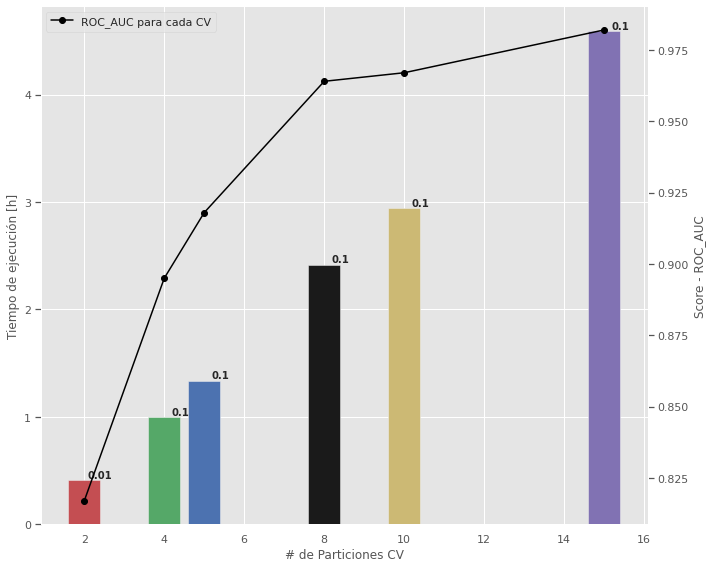

In [ ]:
plt.style.use('ggplot')

fig, ax1 = plt.subplots(figsize=(10,8))
my_colors = 'rgbkymc'
#color = 'tab:blue'
ax1.set_xlabel('# de Particiones CV')
ax1.set_ylabel('Tiempo de ejecución [h]')
ax1.bar(cv_s, cp_time, color=my_colors)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Score - ROC_AUC')  # we already handled the x-label with ax1
ax2.plot(cv_s, scoresgb, marker='o', color='black', label='ROC_AUC para cada CV')
ax2.tick_params(axis='y')
ax2.legend(loc='upper left')
rects = ax1.patches

# Make some labels.

labels = ['0.01','0.1','0.1','0.1','0.1','0.1']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width(), height , label, ha="center", va="bottom", fontweight='bold'
    )

#plt.show()


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(False)
plt.savefig("gridgbm_ss01.jpg", dpi=600)
plt.show()

It is thus clear that the best accuracy score is for a GradientBoosting model with 15 partitions in GridSearch.



## **I. GridSearch training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [ ]:
start_time = timer(None)
parameters = {
    "learning_rate":[0.01,0.1,1, 1.5] 
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
gb = GradientBoostingClassifier(random_state=40, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
gsearch = GridSearchCV(estimator=gb,param_grid=parameters,scoring=scoring, cv=15, refit='AUC', return_train_score=True)
gsearch.fit(X_train,y_train)
print('Mejores parámetros para 10 splits',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Evaluadores',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Mejores parámetros para 10 splits {'learning_rate': 0.1}
Mejor score 0.9924564904138685
Evaluadores {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 3 hours 23 minutes and 50.16 seconds.


(3.0, 23.0, 50.159811999999874)

The roc curve and the confusion matrix are observed to determine how many cases were indeed well predicted by the model. 

In [ ]:
# print best parameter after tuning 
print(gsearch.best_params_) 
grid_predictions = gsearch.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

{'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17760
           1       0.99      0.83      0.91      1746

    accuracy                           0.98     19506
   macro avg       0.99      0.92      0.95     19506
weighted avg       0.98      0.98      0.98     19506



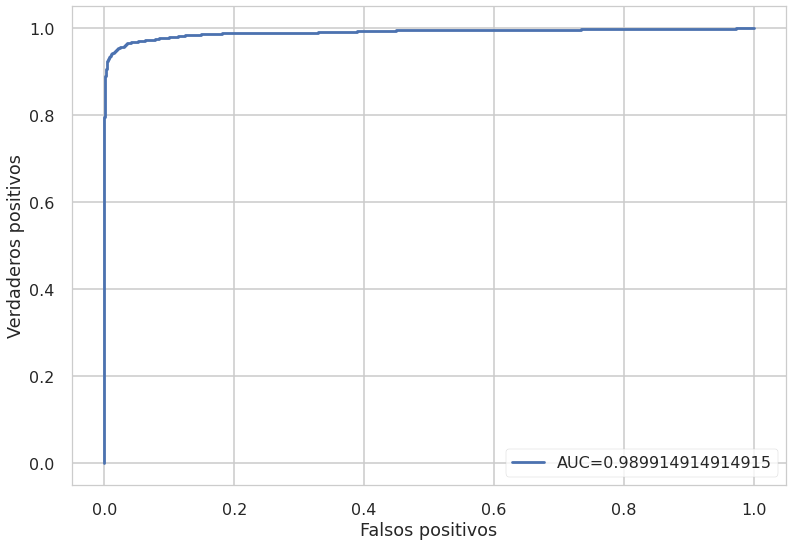

In [ ]:
plt.style.use('seaborn-poster')
y_pred_proba = gsearch.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

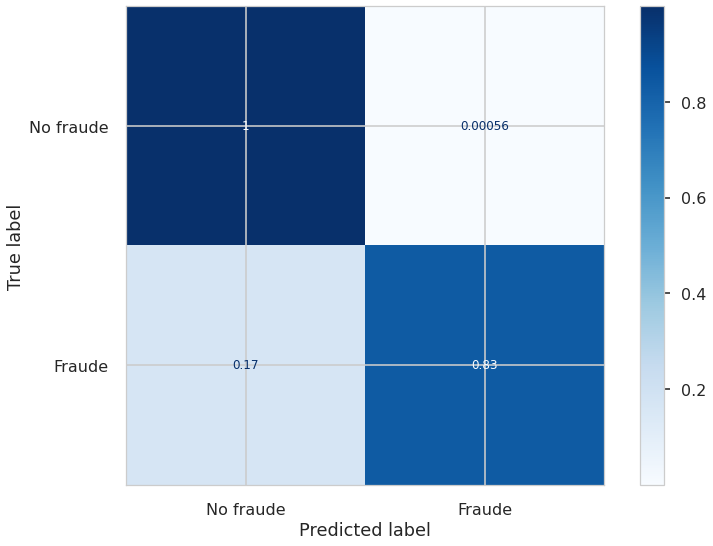

In [ ]:
plot_confusion_matrix(gsearch, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

The model is downloaded with the pickle module for later use.

In [ ]:
# save model to file
pickle.dump(gsearch, open("gridgbm_ss01.pickle.dat", "wb"))

# **5. GridSearch for XGBoost**

## **A. nfolds y seed**

In [ ]:
xgb1 = XGBClassifier(stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic')
parameters1 = {
    "nfolds":[3,5,7,10],
    'seed':[-1, 1, 3, 5]
    #"learning_rate":[0.01,0.1,1, 1.5] 
}
scoring1 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch1 = GridSearchCV(estimator=xgb1,param_grid=parameters1,scoring=scoring1, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch1.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 16 candidates, totalling 128 fits
[CV] nfolds=3, seed=-1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  nfolds=3, seed=-1, AUC=(train=0.976, test=0.483), Accuracy=(train=0.972, test=0.811), F1=(train=0.972, test=0.811), total= 1.1min
[CV] nfolds=3, seed=-1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  nfolds=3, seed=-1, AUC=(train=0.981, test=0.457), Accuracy=(train=0.974, test=0.866), F1=(train=0.974, test=0.866), total= 1.0min
[CV] nfolds=3, seed=-1 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  nfolds=3, seed=-1, AUC=(train=0.967, test=0.855), Accuracy=(train=0.968, test=0.950), F1=(train=0.968, test=0.950), total= 1.0min
[CV] nfolds=3, seed=-1 ...............................................
[CV]  nfolds=3, seed=-1, AUC=(train=0.966, test=0.885), Accuracy=(train=0.968, test=0.893), F1=(train=0.968, test=0.893), total= 1.0min
[CV] nfolds=3, seed=-1 ...............................................
[CV]  nfolds=3, seed=-1, AUC=(train=0.964, test=0.932), Accuracy=(train=0.967, test=0.941), F1=(train=0.967, test=0.941), total= 1.0min
[CV] nfolds=3, seed=-1 ...............................................
[CV]  nfolds=3, seed=-1, AUC=(train=0.962, test=0.968), Accuracy=(train=0.967, test=0.965), F1=(train=0.967, test=0.965), total= 1.0min
[CV] nfolds=3, seed=-1 ...............................................
[CV]  nfolds=3, seed=-1, AUC=(train=0.963, test=0.937), Accuracy=(train=0.966, test=0.966), F1=(train=0.966, test=0.966), total= 1.1min
[CV] nfolds=3, seed=-1 .............

[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed: 139.6min finished



 Time taken: 2 hours 20 minutes and 48.36 seconds.


In [ ]:
gsearch1.best_params_, gsearch1.best_score_


({'nfolds': 3, 'seed': -1}, 0.7620303136825082)

## **B. max_depth**

In [ ]:
xgb2 = XGBClassifier(nfolds=3, seed= -1)
parameters2 = {
    #"ntrees":[100,130,150,200],
    'max_depth':[10,12,15]

}
scoring2 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:
start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch2 = GridSearchCV(estimator=xgb2,param_grid=parameters2,scoring=scoring2, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch2.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 3 candidates, totalling 24 fits
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, AUC=(train=1.000, test=0.497), Accuracy=(train=0.996, test=0.295), F1=(train=0.996, test=0.295), total= 3.2min
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV]  max_depth=10, AUC=(train=1.000, test=0.493), Accuracy=(train=0.997, test=0.704), F1=(train=0.997, test=0.704), total= 3.2min
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.5min remaining:    0.0s


[CV]  max_depth=10, AUC=(train=0.999, test=0.899), Accuracy=(train=0.994, test=0.875), F1=(train=0.994, test=0.875), total= 3.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=0.999, test=0.982), Accuracy=(train=0.994, test=0.846), F1=(train=0.994, test=0.846), total= 3.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=0.999, test=0.993), Accuracy=(train=0.993, test=0.950), F1=(train=0.993, test=0.950), total= 3.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=0.999, test=0.987), Accuracy=(train=0.993, test=0.920), F1=(train=0.993, test=0.920), total= 3.2min
[CV] max_depth=10 ....................................................
[CV]  max_depth=10, AUC=(train=0.999, test=0.993), Accuracy=(train=0.993, test=0.966), F1=(train=0.993, test=0.966), total= 3.2min
[CV] max_depth=10 ...........................................

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 98.6min finished



 Time taken: 1 hours 44 minutes and 33.83 seconds.


In [ ]:
gsearch2.best_params_, gsearch2.best_score_


({'max_depth': 15}, 0.8283158678224622)

## **C. gamma**

In [ ]:
xgb4 = XGBClassifier(stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15)
parameters4 = {
    #"max_depth":[10,15,20,25,35,40],
    'gamma':[i/10.0 for i in range(0,5)]
}
scoring4 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch4 = GridSearchCV(estimator=xgb4,param_grid=parameters4,scoring=scoring4, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch4.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 5 candidates, totalling 40 fits
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.0, AUC=(train=1.000, test=0.500), Accuracy=(train=0.999, test=0.123), F1=(train=0.999, test=0.123), total= 5.1min
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s


[CV]  gamma=0.0, AUC=(train=1.000, test=0.527), Accuracy=(train=1.000, test=0.703), F1=(train=1.000, test=0.703), total= 5.2min
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.5min remaining:    0.0s


[CV]  gamma=0.0, AUC=(train=1.000, test=0.912), Accuracy=(train=0.999, test=0.904), F1=(train=0.999, test=0.904), total= 5.1min
[CV] gamma=0.0 .......................................................
[CV]  gamma=0.0, AUC=(train=1.000, test=0.991), Accuracy=(train=0.999, test=0.903), F1=(train=0.999, test=0.903), total= 5.1min
[CV] gamma=0.0 .......................................................
[CV]  gamma=0.0, AUC=(train=1.000, test=0.995), Accuracy=(train=0.998, test=0.936), F1=(train=0.998, test=0.936), total= 5.1min
[CV] gamma=0.0 .......................................................
[CV]  gamma=0.0, AUC=(train=1.000, test=0.989), Accuracy=(train=0.999, test=0.913), F1=(train=0.999, test=0.913), total= 5.1min
[CV] gamma=0.0 .......................................................
[CV]  gamma=0.0, AUC=(train=1.000, test=0.997), Accuracy=(train=0.998, test=0.977), F1=(train=0.998, test=0.977), total= 5.1min
[CV] gamma=0.0 .......................................................
[CV] 

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 207.4min finished



 Time taken: 3 hours 33 minutes and 22.09 seconds.


In [ ]:
gsearch4.best_params_, gsearch4.best_score_


({'gamma': 0.0}, 0.8283158678224622)

## **D. colsample_bytree**

In [ ]:
xgb5 = XGBClassifier(stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15,gamma=0.0)
parameters5 = {
    #'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
scoring5 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch5 = GridSearchCV(estimator=xgb5,param_grid=parameters5,scoring=scoring5, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch5.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV] colsample_bytree=0.6 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.6, AUC=(train=1.000, test=0.542), Accuracy=(train=0.999, test=0.315), F1=(train=0.999, test=0.315), total= 3.3min
[CV] colsample_bytree=0.6 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV]  colsample_bytree=0.6, AUC=(train=1.000, test=0.468), Accuracy=(train=1.000, test=0.602), F1=(train=1.000, test=0.602), total= 3.3min
[CV] colsample_bytree=0.6 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.8min remaining:    0.0s


[CV]  colsample_bytree=0.6, AUC=(train=1.000, test=0.913), Accuracy=(train=0.999, test=0.914), F1=(train=0.999, test=0.914), total= 3.3min
[CV] colsample_bytree=0.6 ............................................
[CV]  colsample_bytree=0.6, AUC=(train=1.000, test=0.995), Accuracy=(train=0.998, test=0.927), F1=(train=0.998, test=0.927), total= 3.3min
[CV] colsample_bytree=0.6 ............................................
[CV]  colsample_bytree=0.6, AUC=(train=1.000, test=0.996), Accuracy=(train=0.998, test=0.948), F1=(train=0.998, test=0.948), total= 3.3min
[CV] colsample_bytree=0.6 ............................................
[CV]  colsample_bytree=0.6, AUC=(train=1.000, test=0.991), Accuracy=(train=0.998, test=0.926), F1=(train=0.998, test=0.926), total= 3.3min
[CV] colsample_bytree=0.6 ............................................
[CV]  colsample_bytree=0.6, AUC=(train=1.000, test=0.996), Accuracy=(train=0.998, test=0.966), F1=(train=0.998, test=0.966), total= 3.3min
[CV] colsample_bytree

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 129.5min finished



 Time taken: 2 hours 13 minutes and 17.33 seconds.


In [ ]:
gsearch5.best_params_, gsearch5.best_score_


({'colsample_bytree': 0.6}, 0.8373564288431739)

## **E. subsample**

In [ ]:
xgb6 = XGBClassifier(stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15,gamma=0.0,colsample_bytree =0.6)
parameters6 = {
    'subsample':[i/10.0 for i in range(6,10)],
    #'colsample_bytree':[i/10.0 for i in range(6,10)]
}
scoring6 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch6 = GridSearchCV(estimator=xgb6,param_grid=parameters6,scoring=scoring6, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch6.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV] subsample=0.6 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.6, AUC=(train=1.000, test=0.647), Accuracy=(train=0.998, test=0.878), F1=(train=0.998, test=0.878), total= 4.0min
[CV] subsample=0.6 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s


[CV]  subsample=0.6, AUC=(train=1.000, test=0.477), Accuracy=(train=0.999, test=0.666), F1=(train=0.999, test=0.666), total= 3.9min
[CV] subsample=0.6 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.9min remaining:    0.0s


[CV]  subsample=0.6, AUC=(train=1.000, test=0.908), Accuracy=(train=0.997, test=0.898), F1=(train=0.997, test=0.898), total= 4.0min
[CV] subsample=0.6 ...................................................
[CV]  subsample=0.6, AUC=(train=1.000, test=0.992), Accuracy=(train=0.997, test=0.911), F1=(train=0.997, test=0.911), total= 4.0min
[CV] subsample=0.6 ...................................................
[CV]  subsample=0.6, AUC=(train=1.000, test=0.996), Accuracy=(train=0.997, test=0.957), F1=(train=0.997, test=0.957), total= 4.0min
[CV] subsample=0.6 ...................................................
[CV]  subsample=0.6, AUC=(train=1.000, test=0.990), Accuracy=(train=0.997, test=0.933), F1=(train=0.997, test=0.933), total= 4.0min
[CV] subsample=0.6 ...................................................
[CV]  subsample=0.6, AUC=(train=1.000, test=0.997), Accuracy=(train=0.997, test=0.973), F1=(train=0.997, test=0.973), total= 4.0min
[CV] subsample=0.6 .....................................

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 122.9min finished



 Time taken: 2 hours 7 minutes and 32.0 seconds.


In [ ]:
gsearch6.best_params_, gsearch6.best_score_


({'subsample': 0.6}, 0.8629536284772222)

## **F. reg_alpha**

In [ ]:
xgb7 = XGBClassifier(stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15,gamma=0.0,colsample_bytree =0.6,subsample=0.6)
parameters7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
scoring7 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch7 = GridSearchCV(estimator=xgb7,param_grid=parameters7,scoring=scoring7, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch7.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 5 candidates, totalling 40 fits
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_alpha=0, AUC=(train=1.000, test=0.647), Accuracy=(train=0.998, test=0.878), F1=(train=0.998, test=0.878), total= 4.0min
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s


[CV]  reg_alpha=0, AUC=(train=1.000, test=0.477), Accuracy=(train=0.999, test=0.666), F1=(train=0.999, test=0.666), total= 3.9min
[CV] reg_alpha=0 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.0min remaining:    0.0s


[CV]  reg_alpha=0, AUC=(train=1.000, test=0.908), Accuracy=(train=0.997, test=0.898), F1=(train=0.997, test=0.898), total= 4.0min
[CV] reg_alpha=0 .....................................................
[CV]  reg_alpha=0, AUC=(train=1.000, test=0.992), Accuracy=(train=0.997, test=0.911), F1=(train=0.997, test=0.911), total= 4.1min
[CV] reg_alpha=0 .....................................................
[CV]  reg_alpha=0, AUC=(train=1.000, test=0.996), Accuracy=(train=0.997, test=0.957), F1=(train=0.997, test=0.957), total= 4.1min
[CV] reg_alpha=0 .....................................................
[CV]  reg_alpha=0, AUC=(train=1.000, test=0.990), Accuracy=(train=0.997, test=0.933), F1=(train=0.997, test=0.933), total= 4.0min
[CV] reg_alpha=0 .....................................................
[CV]  reg_alpha=0, AUC=(train=1.000, test=0.997), Accuracy=(train=0.997, test=0.973), F1=(train=0.997, test=0.973), total= 4.0min
[CV] reg_alpha=0 .................................................

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 161.7min finished



 Time taken: 2 hours 46 minutes and 21.7 seconds.


In [ ]:
gsearch7.best_params_, gsearch7.best_score_


({'reg_alpha': 0.05}, 0.8630979987057692)

## **G. reg_lambda**

In [ ]:
xgb8 = XGBClassifier(scale_pos_weight = 1,reg_alpha= 0.05, stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15,gamma=0.0,colsample_bytree =0.6,subsample=0.6)
parameters8 = {
    'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
}
scoring8 = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}

In [ ]:

start_time = timer(None) # timing starts from this point for "start_time" variable
gsearch8 = GridSearchCV(estimator=xgb8,param_grid=parameters8,scoring=scoring8, cv=8, verbose=3, refit='AUC', return_train_score=True)
gsearch8.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 8 folds for each of 5 candidates, totalling 40 fits
[CV] reg_lambda=0 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_lambda=0, AUC=(train=1.000, test=0.639), Accuracy=(train=0.999, test=0.821), F1=(train=0.999, test=0.821), total= 3.6min
[CV] reg_lambda=0 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


[CV]  reg_lambda=0, AUC=(train=1.000, test=0.443), Accuracy=(train=1.000, test=0.498), F1=(train=1.000, test=0.498), total= 3.6min
[CV] reg_lambda=0 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.3min remaining:    0.0s


[CV]  reg_lambda=0, AUC=(train=1.000, test=0.910), Accuracy=(train=0.999, test=0.899), F1=(train=0.999, test=0.899), total= 3.6min
[CV] reg_lambda=0 ....................................................
[CV]  reg_lambda=0, AUC=(train=1.000, test=0.993), Accuracy=(train=0.998, test=0.926), F1=(train=0.998, test=0.926), total= 3.7min
[CV] reg_lambda=0 ....................................................
[CV]  reg_lambda=0, AUC=(train=1.000, test=0.996), Accuracy=(train=0.998, test=0.959), F1=(train=0.998, test=0.959), total= 3.7min
[CV] reg_lambda=0 ....................................................
[CV]  reg_lambda=0, AUC=(train=1.000, test=0.992), Accuracy=(train=0.998, test=0.937), F1=(train=0.998, test=0.937), total= 3.7min
[CV] reg_lambda=0 ....................................................
[CV]  reg_lambda=0, AUC=(train=1.000, test=0.998), Accuracy=(train=0.998, test=0.978), F1=(train=0.998, test=0.978), total= 3.7min
[CV] reg_lambda=0 ...........................................

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 148.1min finished



 Time taken: 2 hours 32 minutes and 19.69 seconds.


In [ ]:
gsearch8.best_params_, gsearch8.best_score_


({'reg_lambda': 0.005}, 0.8585399838647257)

## **H. Learning_rate y cv** 


### **H.1. For 2,3,5,8 and 10 cv partitions**




In [ ]:
cv=[2,3,5,8,10] 
scores,tiempo,param=[],[],[]
for crosval in cv:
  
  start_time = timer(None)
  parameters = {
      "eta":[0.01,0.1,1, 1.5] 
  }
  scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
  xgb = XGBClassifier(scale_pos_weight = 1,reg_alpha= 0.05, stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15,gamma=0.0,colsample_bytree =0.6,subsample=0.6)
  gsearch = GridSearchCV(estimator=xgb,param_grid=parameters,scoring=scoring, cv=crosval, refit='AUC', return_train_score=True)
  gsearch.fit(X,Y)
  scores.append(np.round((gsearch.best_score_*100),2))
  h,m,s=timer(start_time)
  tiempo.append((h+(m/60)+(s/3600)))
  lrate=gsearch.best_params_
  param.append(lrate['eta'])
  print('Con CV:',crosval)
  print('Mejores parámetros',gsearch.best_params_)
  print('Mejor score',gsearch.best_score_)
  print('Mejores evaluaciones',gsearch.scorer_)
  print('-'*40)
    
  
   # timing starts from this point for "start_time" variable


 Time taken: 0 hours 21 minutes and 43.93 seconds.
Con CV: 2
Mejores parámetros {'eta': 0.01}
Mejor score 0.6931025855375578
Mejores evaluaciones {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}
----------------------------------------

 Time taken: 0 hours 40 minutes and 54.93 seconds.
Con CV: 3
Mejores parámetros {'eta': 0.01}
Mejor score 0.7293348809182305
Mejores evaluaciones {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}
----------------------------------------

 Time taken: 1 hours 19 minutes and 21.82 seconds.
Con CV: 5
Mejores parámetros {'eta': 0.01}
Mejor score 0.8101216746305558
Mejores evaluaciones {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}
----------------------------------------

 Time 

### **Analysis obtained from the GridSearch with respect to the number of partitions**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


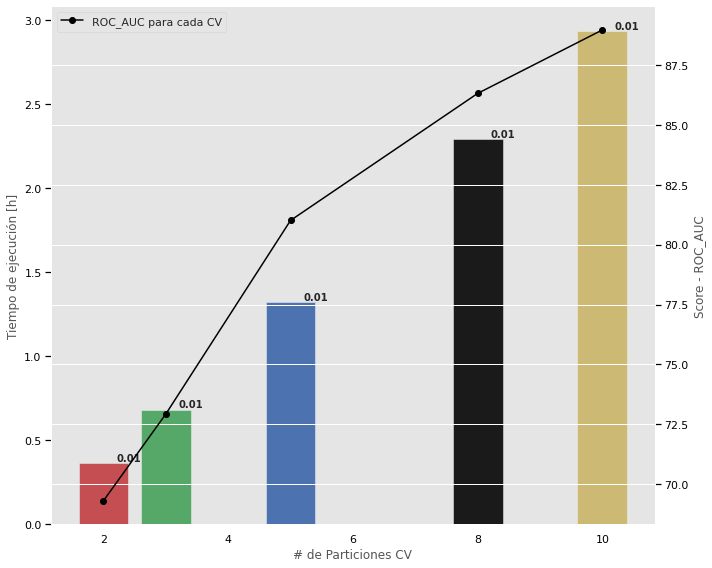

In [ ]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(10,8))
my_colors = 'rgbkymc'
#color = 'tab:blue'
ax1.set_xlabel('# de Particiones CV')
ax1.set_ylabel('Tiempo de ejecución [h]')
ax1.bar(cv, tiempo, color=my_colors)
ax1.tick_params(axis='y')
ax1.grid(False)
ax1.tick_params(axis='both',colors='black') 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Score - ROC_AUC')  # we already handled the x-label with ax1
ax2.plot(cv, scores, marker='o', color='black', label='ROC_AUC para cada CV')
ax2.tick_params(axis='y')
ax2.legend(loc='upper left')
ax2.tick_params(axis='both',colors='black') 
rects = ax1.patches

# Make some labels.

for rect, label in zip(rects, param):
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width(), height , label, ha="center", va="bottom", fontweight='bold'
    )

#plt.show()


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("gridxgb_ss01.svg", dpi=600)
#plt.show()

In [ ]:
plt.savefig("gbm_n01.jpg", dpi=600)


<Figure size 640x480 with 0 Axes>

cambiar por tiempo de ejecución
hacer entrenamiento también con gridsearch y luego comparar con gradientB solo 

## **I. GridSearch training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [ ]:
start_time = timer(None)
parameters = {
    "eta":[0.01,0.1,1]  
}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1':make_scorer(f1_score, average='micro')}
xgb = XGBClassifier(scale_pos_weight = 1,reg_alpha= 0.05, stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15,gamma=0.0,colsample_bytree =0.6,subsample=0.6)
gsearch = GridSearchCV(estimator=xgb,param_grid=parameters,scoring=scoring, cv=10, refit='AUC', return_train_score=True, verbose=3)
gsearch.fit(X_train,y_train)
print('Mejores parámetros para 10 splits',gsearch.best_params_)
print('Mejor score',gsearch.best_score_)
print('Evaluadores',gsearch.scorer_)
  

 # timing starts from this point for "start_time" variable
timer(start_time)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] eta=0.01 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  eta=0.01, AUC=(train=1.000, test=0.992), Accuracy=(train=0.997, test=0.987), F1=(train=0.997, test=0.987), total= 3.2min
[CV] eta=0.01 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s


[CV]  eta=0.01, AUC=(train=1.000, test=0.989), Accuracy=(train=0.997, test=0.985), F1=(train=0.997, test=0.985), total= 3.1min
[CV] eta=0.01 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.4min remaining:    0.0s


[CV]  eta=0.01, AUC=(train=1.000, test=0.990), Accuracy=(train=0.997, test=0.987), F1=(train=0.997, test=0.987), total= 3.2min
[CV] eta=0.01 ........................................................
[CV]  eta=0.01, AUC=(train=1.000, test=0.980), Accuracy=(train=0.997, test=0.984), F1=(train=0.997, test=0.984), total= 3.2min
[CV] eta=0.01 ........................................................
[CV]  eta=0.01, AUC=(train=1.000, test=0.991), Accuracy=(train=0.997, test=0.988), F1=(train=0.997, test=0.988), total= 3.2min
[CV] eta=0.01 ........................................................
[CV]  eta=0.01, AUC=(train=1.000, test=0.990), Accuracy=(train=0.997, test=0.987), F1=(train=0.997, test=0.987), total= 3.3min
[CV] eta=0.01 ........................................................
[CV]  eta=0.01, AUC=(train=1.000, test=0.993), Accuracy=(train=0.997, test=0.986), F1=(train=0.997, test=0.986), total= 3.3min
[CV] eta=0.01 ........................................................
[CV]  eta=

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 99.2min finished


Mejores parámetros para 10 splits {'eta': 0.01}
Mejor score 0.9898916968515301
Evaluadores {'AUC': make_scorer(roc_auc_score, needs_threshold=True), 'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average=micro)}

 Time taken: 1 hours 42 minutes and 50.02 seconds.


(1.0, 42.0, 50.02266400000008)

In [ ]:
# print best parameter after tuning 
print(gsearch.best_params_) 
grid_predictions = gsearch.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

{'eta': 0.01}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17760
           1       0.99      0.84      0.91      1746

    accuracy                           0.99     19506
   macro avg       0.99      0.92      0.95     19506
weighted avg       0.99      0.99      0.98     19506



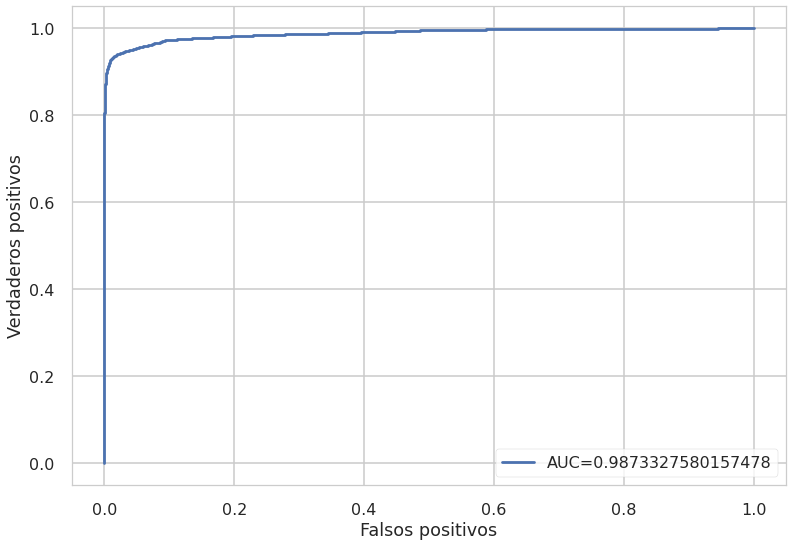

In [ ]:
plt.style.use('seaborn-poster')
y_pred_proba = gsearch.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

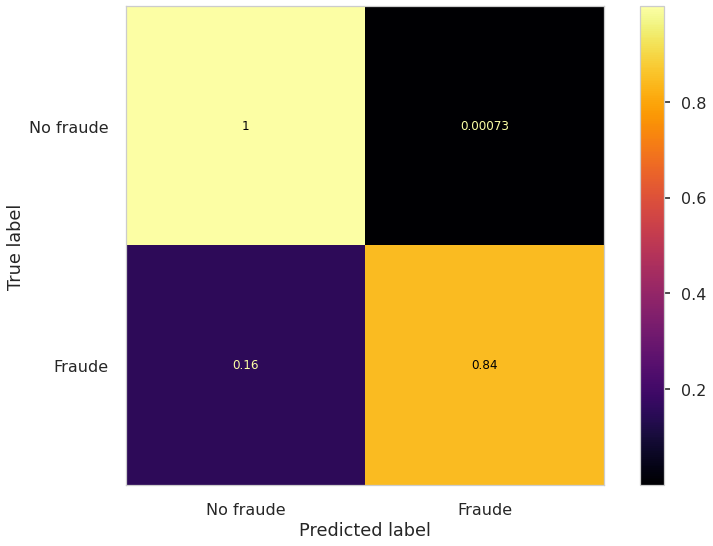

In [ ]:
plot_confusion_matrix(gsearch, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='inferno')
plt.grid(False)

In [ ]:
# save model to file
pickle.dump(gsearch, open("gridxgb_ss01.pickle.dat", "wb"))

As a final conclusion, the following can be said: First, that despite the difference of both models with respect to the calculated accuracy and partitions during the GridSearch, the truth is that both present a quite similar ROC_AUC curve (with decimal differences). Regarding the correlation matrix found to compare the prediction of both models, we obtain that XGBoost predicts better the fraud label (only 16% wrong) while with GradientBoosting this percentage increases a little to 17% of misclassification. 
